In [1]:
import numpy as np 
import pandas as pd 
import os

In [2]:
!pip install segmentation_models --no-index --find-links=file:///kaggle/input/seg-models-offline

Looking in links: file:///kaggle/input/seg-models-offline
Processing /kaggle/input/seg-models-offline/segmentation_models-1.0.1-py3-none-any.whl
Processing /kaggle/input/seg-models-offline/image_classifiers-1.0.0-py3-none-any.whl
Processing /kaggle/input/seg-models-offline/Keras_Applications-1.0.8-py3-none-any.whl
Processing /kaggle/input/seg-models-offline/efficientnet-1.0.0-py3-none-any.whl


In [3]:
#!pip install -q ../input/qubvel/efficientnet-1.0.0-py3-none-any.whl
#!pip install -q ../input/qubvel/image_classifiers-1.0.0-py3-none-any.whl
#!pip install -q ../input/qubvel/segmentation_models-1.0.0-py3-none-any.whl

In [4]:
import segmentation_models as sm
sm.set_framework('tf.keras')

sm.framework()
from segmentation_models import Unet

Segmentation Models: using `keras` framework.


In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import keras
import glob
from tensorflow.keras.utils import Sequence
from keras import backend as K
from keras.losses import binary_crossentropy
import tensorflow as tf


from keras import layers
from keras.layers import BatchNormalization

In [6]:
train_df = pd.read_csv("../input/hubmap-organ-segmentation/train.csv")
test_df = pd.read_csv("../input/hubmap-organ-segmentation/test.csv")


In [7]:
train_df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female
...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male


In [8]:
train_df['img_height'].value_counts()

3000    326
2631      2
2416      2
2942      2
2790      2
2764      2
2654      2
2539      1
2680      1
2727      1
2308      1
2867      1
2783      1
2869      1
2760      1
2630      1
2511      1
2593      1
2675      1
3070      1
Name: img_height, dtype: int64

In [9]:
train_df['img_width'].value_counts()

3000    326
2631      2
2416      2
2942      2
2790      2
2764      2
2654      2
2539      1
2680      1
2727      1
2308      1
2867      1
2783      1
2869      1
2760      1
2630      1
2511      1
2593      1
2675      1
3070      1
Name: img_width, dtype: int64

In [10]:
pd.crosstab(train_df['img_height'],train_df['img_width'])

#Height=Width for all images

img_width,2308,2416,2511,2539,2593,2630,2631,2654,2675,2680,2727,2760,2764,2783,2790,2867,2869,2942,3000,3070
img_height,,,,,,,,,,,,,,,,,,,,
2308,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2416,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2511,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2539,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2593,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2630,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2631,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
2654,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0
2675,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [11]:
print('Minimum width:',train_df['img_width'].min())
print('Maximum width:',train_df['img_width'].max())
print('Minimum height:',train_df['img_height'].min())
print('Maximum height:',train_df['img_height'].max())

Minimum width: 2308
Maximum width: 3070
Minimum height: 2308
Maximum height: 3070


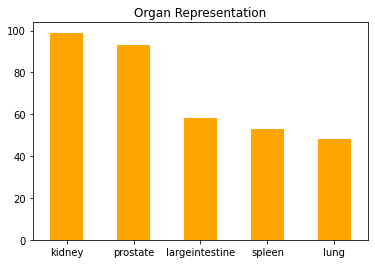

In [12]:
train_df['organ'].value_counts().plot(kind='bar',color='orange')
plt.title('Organ Representation')
plt.xticks(rotation=360)
plt.show()

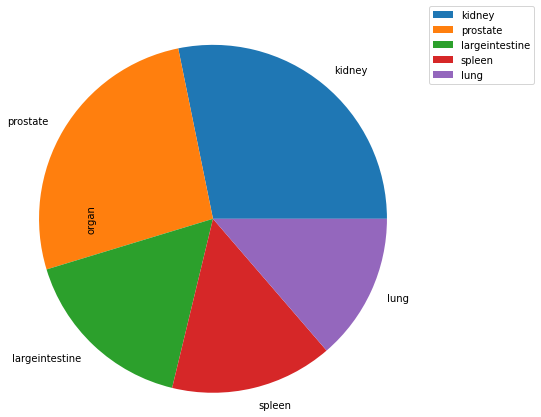

In [13]:
train_df['organ'].value_counts().plot(kind='pie',radius=2)
plt.legend(bbox_to_anchor=(1, 1., 1, 0.5))
plt.show()

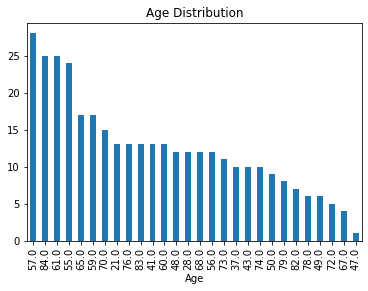

In [14]:
train_df['age'].value_counts().plot(kind='bar')
plt.title("Age Distribution")
plt.xlabel("Age")
plt.show()


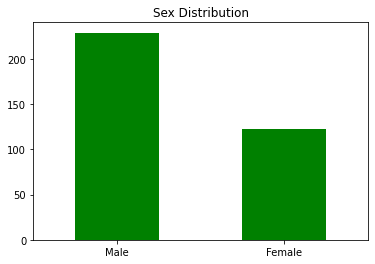

In [15]:
train_df['sex'].value_counts().plot(kind='bar',color='green')
plt.title('Sex Distribution')
plt.xticks(rotation=360)
plt.show()

In [16]:
train_df['pixel_size'].value_counts()

0.4    351
Name: pixel_size, dtype: int64

In [17]:
train_df['tissue_thickness'].value_counts()

4    351
Name: tissue_thickness, dtype: int64

In [18]:
#helper functions
def rle_decoder(n,df= train_df):
    
    ht = int(df['img_height'][n])
    wt = int(df['img_width'][n])
    
    mask = np.zeros((ht * wt),dtype = np.uint8)
    values = np.asarray(df['rle'][n].split(" "),dtype='int')
    
    start_pt = values[::2] - 1
    length = values[1::2]
    end_pt = start_pt + length
    
    for start, end in zip(start_pt, end_pt):
        mask[start:end] = 1
    

    mask = mask.reshape(wt,ht)
    mask = mask.T
    mask = mask.astype(np.uint8)
    return mask

def mask_to_rle(img):
    pixels = img.T.flatten()
    pixels = np.concatenate([[0],pixels,[0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] 
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

**Plotting Images**

Before plotting, let us merge the train_images file path to our train.csv dataframe

In [19]:
train_img_path = glob.glob('../input/hubmap-organ-segmentation/train_images/*')
paths_df = pd.DataFrame(columns=['paths'])
paths_df['paths'] = train_img_path

paths_df['id'] = paths_df['paths'].apply(lambda x: x.split('/')[-1].replace('.tiff',"")).astype('int')

train_df = train_df.merge(paths_df,on='id')


In [20]:
train_df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,paths
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../input/hubmap-organ-segmentation/train_image...
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../input/hubmap-organ-segmentation/train_image...
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../input/hubmap-organ-segmentation/train_image...
3,10488,lung,HPA,3000,3000,0.4,4,3446519 15 3449517 17 3452514 20 3455510 24 34...,78.0,Male,../input/hubmap-organ-segmentation/train_image...
4,10610,spleen,HPA,3000,3000,0.4,4,478925 68 481909 87 484893 105 487863 154 4908...,21.0,Female,../input/hubmap-organ-segmentation/train_image...
...,...,...,...,...,...,...,...,...,...,...,...
346,9517,kidney,HPA,3000,3000,0.4,4,1611763 11 1614753 29 1617750 35 1620746 43 16...,61.0,Male,../input/hubmap-organ-segmentation/train_image...
347,9769,kidney,HPA,3070,3070,0.4,4,4030400 28 4033466 34 4036526 48 4039594 54 40...,28.0,Male,../input/hubmap-organ-segmentation/train_image...
348,9777,largeintestine,HPA,3000,3000,0.4,4,538473 13 541468 22 544463 30 547461 35 550459...,84.0,Male,../input/hubmap-organ-segmentation/train_image...
349,9791,kidney,HPA,3000,3000,0.4,4,334733 33 337729 43 340729 43 343725 51 346723...,28.0,Male,../input/hubmap-organ-segmentation/train_image...


Display images with and without masks


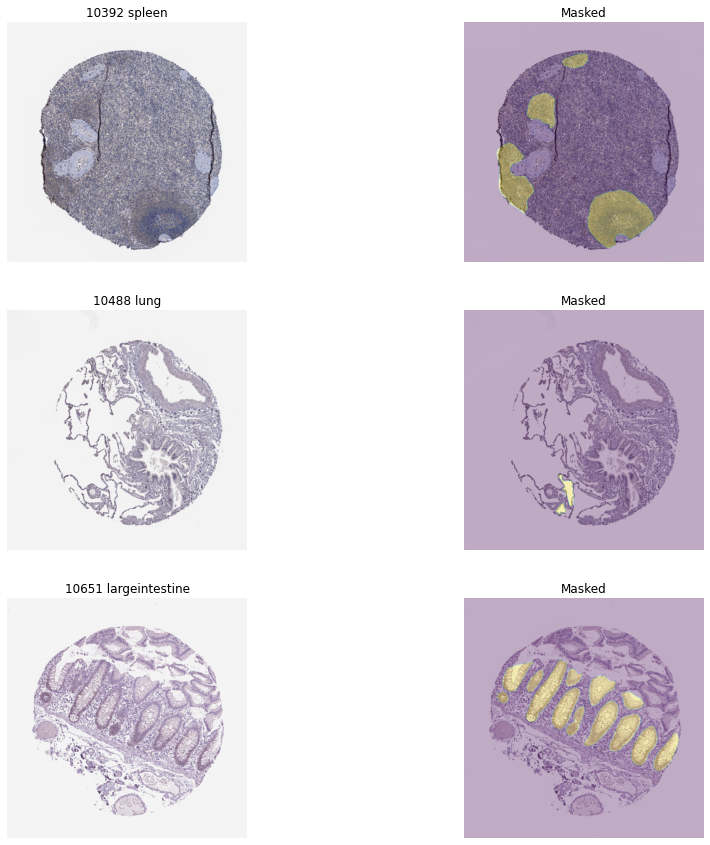

In [21]:
plt.figure(figsize=(15,15))
n = [2,3,6]
a = 1
for i in n:
    img1 = Image.open(train_df['paths'][i])
    img1 = np.array(img1)
    plt.subplot(3,2,a)
    plt.title(str(train_df['id'][i])+' '+str(train_df['organ'][i]))
    plt.axis('off')
    plt.imshow(img1,alpha=1)
    a = a + 1

    plt.subplot(3,2,a)
    plt.imshow(img1)
    plt.subplot(3,2,a)
    plt.axis('off')
    plt.title('Masked')
    plt.imshow(rle_decoder(i,train_df),alpha=0.3)
    a = a + 1
    

**Building datagenerator**

In [22]:


class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, df, batch_size=16, n_classes=5, shuffle=False,to_fit=True):
  
        'Initialization'
        self.df = df
        self.to_fit = to_fit
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.df))
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size: (index+1)*self.batch_size]
        X = np.empty((self.batch_size,512,512,3),dtype=np.float32)
        y = np.empty((self.batch_size,512,512,1),dtype=np.uint8)
        
        if self.to_fit == True:
            
            for i, img_path in enumerate(self.df['paths'].iloc[indexes]):
                img = self.read_img(img_path)
                X[i,] = img
                dims = int(self.df['img_height'].iloc[indexes[i]])
                mask = self.get_mask(dims,indexes[i])
                y[i,] = mask
                
            
            return X, y
          
        else:
            for i, img_path in enumerate(self.df['paths'].iloc[indexes]):
                img = self.read_img(img_path)
                X[i,] = img
                
            return X
        
        
    def read_img(self, path):
        image =  Image.open(path)
        image = image.resize((512,512))
        image = np.asarray(image)
        image = image.astype(np.float32)
        return image/255
    
    def get_mask(self,dim,n):
    
        mask = np.zeros((dim * dim),dtype = np.uint8)
        values = np.asarray(self.df['rle'].iloc[n].split(" "),dtype='int')
    
        start_pt = values[::2] - 1
        length = values[1::2]
        end_pt = start_pt + length
    
        for start, end in zip(start_pt, end_pt):
            mask[start:end] = 1
    

        mask = mask.reshape(dim,dim)
        mask = mask.T
        mask = mask.astype(np.uint8)
        
        res = cv2.resize(mask, dsize=(512, 512))
        res = np.expand_dims(res, axis=-1)
        
        return res

In [23]:
from sklearn.model_selection import train_test_split

y = train_df['organ']
train,val = train_test_split(train_df,test_size=0.1,stratify=y)
train

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,paths
264,32231,spleen,HPA,3000,3000,0.4,4,1399958 26 1402957 29 1405956 32 1408947 48 14...,72.0,Male,../input/hubmap-organ-segmentation/train_image...
274,4066,kidney,HPA,3000,3000,0.4,4,859216 25 862210 34 865207 39 868204 44 871201...,70.0,Male,../input/hubmap-organ-segmentation/train_image...
71,16564,lung,HPA,3000,3000,0.4,4,3491396 12 3494392 18 3497390 22 3500389 25 35...,43.0,Female,../input/hubmap-organ-segmentation/train_image...
97,19084,prostate,HPA,3000,3000,0.4,4,952518 47 955517 50 958516 52 961505 70 964504...,55.0,Male,../input/hubmap-organ-segmentation/train_image...
162,2447,kidney,HPA,3000,3000,0.4,4,990994 32 993994 33 996991 44 999989 50 100298...,28.0,Male,../input/hubmap-organ-segmentation/train_image...
...,...,...,...,...,...,...,...,...,...,...,...
247,30876,kidney,HPA,3000,3000,0.4,4,2527873 31 2530868 42 2533859 54 2536844 76 25...,61.0,Male,../input/hubmap-organ-segmentation/train_image...
165,24833,spleen,HPA,3000,3000,0.4,4,1956905 6 1959904 7 1962903 8 1965902 9 196890...,50.0,Female,../input/hubmap-organ-segmentation/train_image...
20,11662,largeintestine,HPA,3000,3000,0.4,4,673655 29 676649 41 679645 47 682638 59 685636...,84.0,Female,../input/hubmap-organ-segmentation/train_image...
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../input/hubmap-organ-segmentation/train_image...


In [24]:
train_gen = DataGenerator(df = train,shuffle=True,batch_size=4)
val_gen = DataGenerator(df = val,shuffle=True,batch_size=4)

In [25]:
model = Unet('efficientnetb6', input_shape=(512, 512, 3), encoder_weights='imagenet', activation='sigmoid',classes=1,encoder_freeze=True)



2022-08-27 14:28:32.633289: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 14:28:32.774654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 14:28:32.775492: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-27 14:28:32.777282: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

165535744/165527152 [==============================] - 6s 0us/step


In [26]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('unet_model', monitor="val_accuracy",save_best_only=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",patience = 5, mode='min',factor=0.1,min_lr=0.00001),
            tf.keras.callbacks.EarlyStopping(patience=5,monitor = 'val_loss')]

In [27]:
#model.summary()

In [28]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [29]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    use_multiprocessing=False,
    epochs=10
 )

2022-08-27 14:28:49.179208: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-08-27 14:29:12.692651: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


78/78 [==============================] - 180s 2s/step - loss: 0.2757 - accuracy: 0.8909 - val_loss: 0.6299 - val_accuracy: 0.8781
Epoch 2/10
78/78 [==============================] - 108s 1s/step - loss: 0.1811 - accuracy: 0.9249 - val_loss: 0.9004 - val_accuracy: 0.7293
Epoch 3/10
78/78 [==============================] - 82s 1s/step - loss: 0.1617 - accuracy: 0.9350 - val_loss: 0.1912 - val_accuracy: 0.9226
Epoch 4/10
78/78 [==============================] - 80s 1s/step - loss: 0.1430 - accuracy: 0.9442 - val_loss: 0.1352 - val_accuracy: 0.9456
Epoch 5/10
78/78 [==============================] - 81s 1s/step - loss: 0.1340 - accuracy: 0.9461 - val_loss: 0.1280 - val_accuracy: 0.9468
Epoch 6/10
78/78 [==============================] - 82s 1s/step - loss: 0.1350 - accuracy: 0.9461 - val_loss: 0.3346 - val_accuracy: 0.9032
Epoch 7/10
78/78 [==============================] - 81s 1s/step - loss: 0.1254 - accuracy: 0.9503 - val_loss: 0.2107 - val_accuracy: 0.9314
Epoch 8/10
78/78 [===========

In [30]:
for layers in model.layers:
    layers.trainable = True
    
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [31]:
history = model.fit(train_gen,
                   validation_data = val_gen,
                   callbacks = callbacks,
                   epochs = 50)

Epoch 1/50
78/78 [==============================] - 114s 1s/step - loss: 0.0903 - accuracy: 0.9653 - val_loss: 0.1029 - val_accuracy: 0.9591


2022-08-27 14:47:15.426222: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
78/78 [==============================] - 121s 2s/step - loss: 0.0813 - accuracy: 0.9689 - val_loss: 0.1038 - val_accuracy: 0.9578
Epoch 3/50
78/78 [==============================] - 105s 1s/step - loss: 0.0729 - accuracy: 0.9725 - val_loss: 0.1119 - val_accuracy: 0.9566
Epoch 4/50
78/78 [==============================] - 108s 1s/step - loss: 0.0678 - accuracy: 0.9745 - val_loss: 0.1084 - val_accuracy: 0.9575
Epoch 5/50
78/78 [==============================] - 111s 1s/step - loss: 0.0659 - accuracy: 0.9753 - val_loss: 0.1114 - val_accuracy: 0.9573
Epoch 6/50
78/78 [==============================] - 100s 1s/step - loss: 0.0593 - accuracy: 0.9776 - val_loss: 0.1062 - val_accuracy: 0.9598


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [32]:
check_df = pd.DataFrame(train_df.iloc[0:3])
check_df

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,rle,age,sex,paths
0,10044,prostate,HPA,3000,3000,0.4,4,1459676 77 1462675 82 1465674 87 1468673 92 14...,37.0,Male,../input/hubmap-organ-segmentation/train_image...
1,10274,prostate,HPA,3000,3000,0.4,4,715707 2 718705 8 721703 11 724701 18 727692 3...,76.0,Male,../input/hubmap-organ-segmentation/train_image...
2,10392,spleen,HPA,3000,3000,0.4,4,1228631 20 1231629 24 1234624 40 1237623 47 12...,82.0,Male,../input/hubmap-organ-segmentation/train_image...


In [33]:
def preprocess_image(path):
    image = tf.keras.utils.load_img(path)
    original_shape = tf.keras.utils.img_to_array(image).shape
    image_processed = tf.keras.utils.img_to_array(tf.keras.utils.array_to_img(image).resize((512, 512)))/255
    return image_processed,original_shape

In [34]:
test_gen = DataGenerator(test_df,batch_size=1,to_fit=False)
check_gen = DataGenerator(check_df,batch_size=1,to_fit=False)

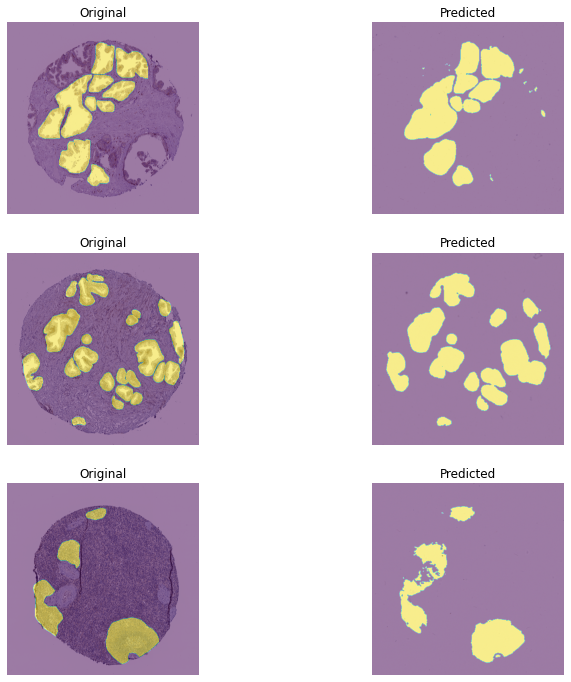

In [35]:

check_predictions = model.predict(check_gen)
check_mask = np.where(check_predictions > 0.5,1,0)
check_mask.shape

plt.figure(figsize=(12,12))
a = 1
for i in range(len(check_df)):
    
    img = Image.open(check_df['paths'][i])
    img = np.array(img)
    plt.subplot(3,2,a)
    plt.title('Original')
    plt.axis('off')
    plt.imshow(img)
    plt.subplot(3,2,a)
    plt.imshow(rle_decoder(i,check_df),alpha=0.5)
    
    
    plt.subplot(3,2,a+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title('Predicted')
    plt.subplot(3,2,a+1)
    plt.imshow(check_mask[i],alpha=0.5)
    
    a+=2

In [36]:
#test_df = pd.read_csv('../input/hubmap-organ-segmentation/test.csv')
#test_ids = test_df['id']
#test_dir = '../input/hubmap-organ-segmentation/test_images'

#ids = []
#rles = []
#for id in test_ids:
    #path = os.path.join(test_dir, f"{id}.tiff")
    #image,original_shape = preprocess_image(path)
    #pred = model.predict(np.expand_dims(image, axis=0))
    #pred_mask = np.where(pred > 0.5, 1, 0)[0]
    #resized_pred_mask = tf.keras.utils.array_to_img(pred_mask, scale=False).resize((original_shape[0], original_shape[1]), resample=0)
    #resized_pred_mask_array = tf.keras.utils.img_to_array(resized_pred_mask, dtype='uint8')
    #rle = mask_to_rle(resized_pred_mask_array)
    #ids.append(id)
    #rles.append(rle)
    
#submission_df = pd.DataFrame({'id':ids,'rle':rles})
#submission_df.to_csv('submission.csv', index=False)

In [37]:
#submission_df